In [1]:
# importing libraries
import os
import os.path as op
import shutil
import warnings
import zipfile
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import yaml

warnings.filterwarnings("ignore")
SEED = 0

In [2]:
def readyaml(file_path):
    with open(file_path, "r") as yaml_file:
        config = yaml.safe_load(yaml_file)
    return config

config_path = Path().resolve() / "conf" / "config.yaml"
config = readyaml(config_path)
datasets = config['datasets']
download_path = str(Path("..") / datasets["abs_path"])
train_path = Path("..") / datasets["train"]
test_path = Path("..") / datasets["test"]
raw_path = Path("..") / datasets["raw"]
overwrite = datasets["overwrite"]


In [3]:
# Downloading data
os.makedirs(download_path, exist_ok=True)
!kaggle competitions download -c titanic -p $download_path

os.makedirs(test_path, exist_ok=True)
os.makedirs(train_path, exist_ok=True)
os.makedirs(raw_path, exist_ok=True)

with zipfile.ZipFile(Path(download_path) / "titanic.zip", "r") as zip_file:
    zip_file.extractall(raw_path)

# Construct source file paths
train_source_path = op.join(raw_path, "train.csv")
test_source_path = op.join(raw_path, "test.csv")

# Check if the destination file already exists
if op.exists(op.join(train_path, "train.csv")):
    if overwrite:
        # Remove the existing file
        os.remove(op.join(train_path, "train.csv"))
        # Move train.csv to train_path, overwriting the existing file
        shutil.move(train_source_path, train_path)
    else:
        # Remove the new file
        os.remove(train_source_path)
        # Handle the case where the file should not be overwritten
        print("Destination file already exists and overwrite is set to False. File not moved.")


if op.exists(op.join(test_path, "test.csv")):
    if overwrite:
        # Remove the existing file
        os.remove(op.join(test_path, "test.csv"))
        # Move train.csv to train_path, overwriting the existing file
        shutil.move(test_source_path, test_path)
    else:
        # Remove the existing file
        os.remove(test_source_path)
        # Handle the case where the file should not be overwritten
        print("Destination file already exists and overwrite is set to False. File not moved.")
else:
    # Move train.csv to train_path
    shutil.move(train_source_path, train_path)
    # Move test.csv to test_path
    shutil.move(test_source_path, test_path)

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [11]:
# Data info

df_train = pd.read_csv(Path(train_path) / "train.csv")
df_test = pd.read_csv(Path(test_path) / "test.csv")

In [14]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [16]:
df_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [76]:
# Handling missing values
# In the current dataset, we have missing values only for age, cabin and Embarked

male_df = df_train[df_train['Sex'] == 'male']
male_avg = male_df['Age'].mean()

female_df = df_train[df_train['Sex'] == 'female']
female_avg = female_df['Age'].mean()

female_avg


27.915708812260537

In [75]:
df_train['Embarked'].value_counts()

# Embarked missing values replace with the mode

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [23]:
df_train.value_counts(df_train['Survived'])

Survived
0    549
1    342
Name: count, dtype: int64

<Figure size 600x400 with 0 Axes>

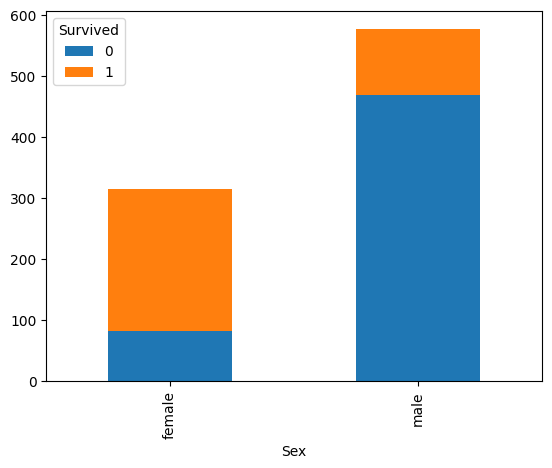

In [46]:
grouped = df_train.groupby(['Sex', 'Survived']).size().unstack()

plt.figure(figsize=(6,4))
grouped.plot(kind='bar', stacked=True)

plt.show()

From the above visual, we can see that females survival chances are more when compared to male

In [50]:
grouped_Pclass = df_train.groupby(['Pclass', 'Sex', 'Survived']).size().unstack()
grouped_Pclass

Survived         0   1
Pclass Sex            
1      female    3  91
       male     77  45
2      female    6  70
       male     91  17
3      female   72  72
       male    300  47

From the above counts, we see that for each Pclass, females have more survival chances than that of males. Other than that, Pclass 1 has more chances of survival

In [61]:
df_train['Parch'].value_counts()

Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64

In [57]:
df_train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

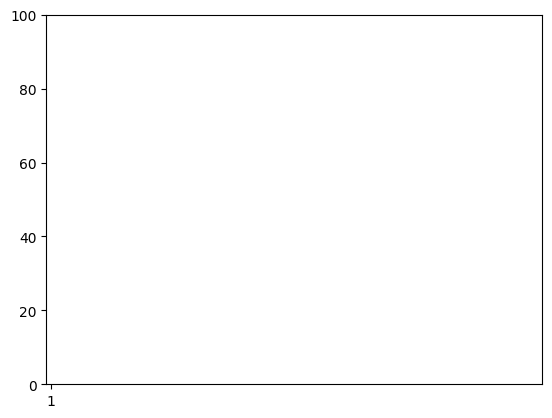